In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

# Classification Overview

## Problem statement and datasets

A model that maps continuous or discrete inputs to a discrete (ordinal, categorical, or integer) output space. In this course we will focus primarily on problems with continuous inputs.

### Toy datasets

Since this problem type is significantly different than what we have seen before, we will introduce a few new datasets in this module. First, we will consider some "toy" datasets that can be generated using `scikit-learn`:

/Users/SihoonChoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


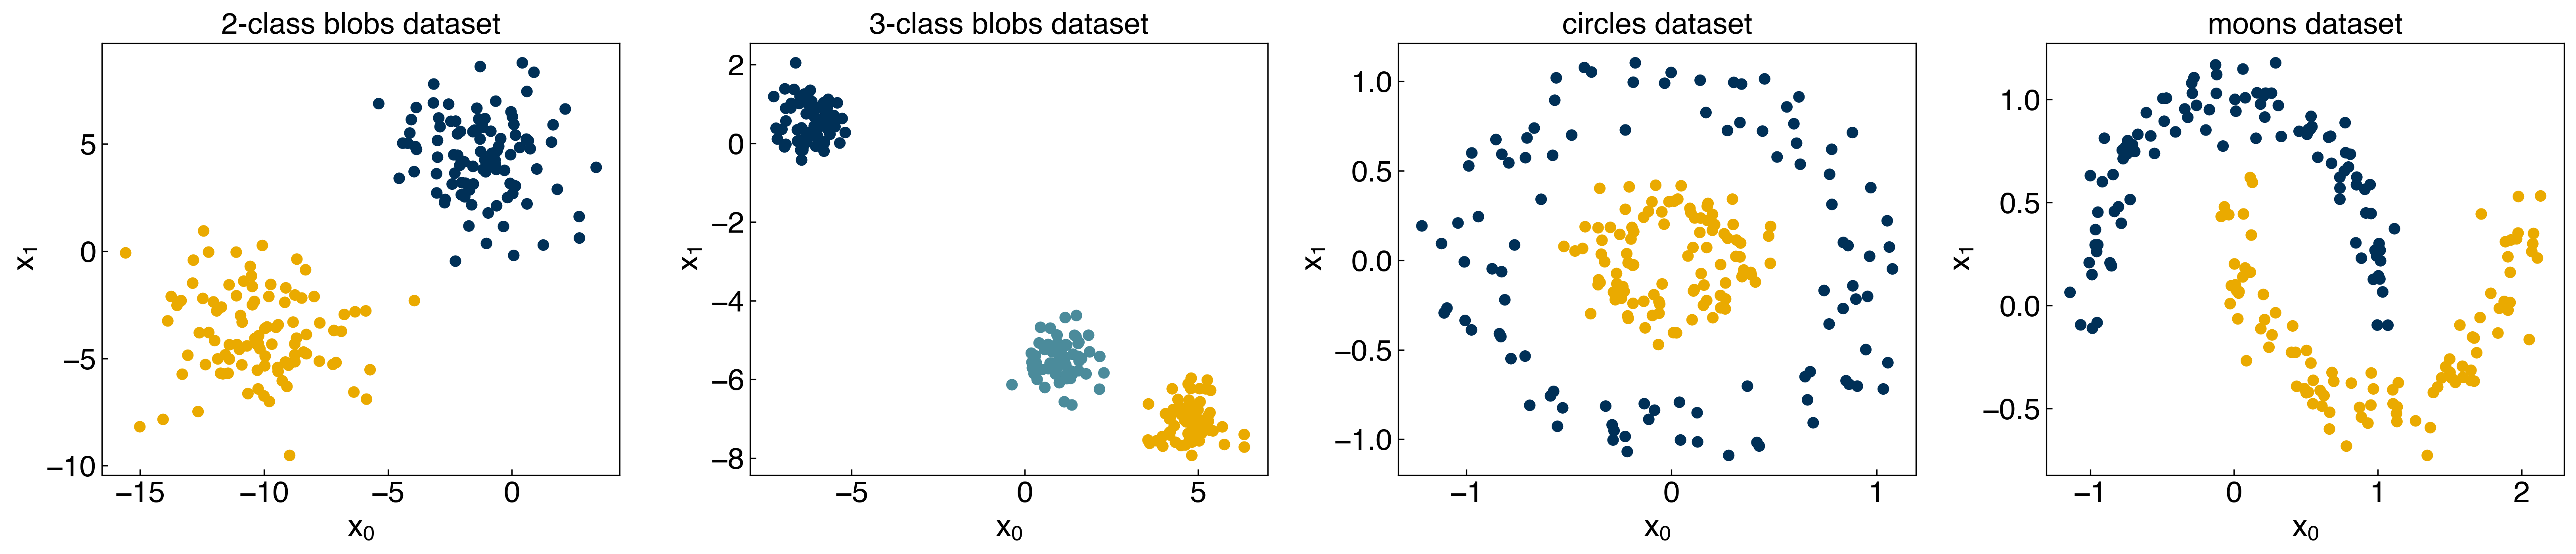

In [3]:
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
np.random.seed(1) #make sure the same random samples are generated each time

noisiness = 1

X_blob, y_blob = make_blobs(n_samples=200, centers=2, cluster_std=2*noisiness, n_features=2)

X_mc, y_mc = make_blobs(n_samples=200, centers=3, cluster_std=0.5*noisiness, n_features=2)

X_circles, y_circles = make_circles(n_samples=200, factor=0.3, noise=0.1*noisiness)

X_moons, y_moons = make_moons(n_samples=200, noise=0.1*noisiness)

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

all_datasets = [[X_blob, y_blob], [X_mc, y_mc], [X_circles, y_circles], [X_moons, y_moons]]
titles = ['2-class blobs dataset', '3-class blobs dataset', 'circles dataset', 'moons dataset']

for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:,0], Xi[:,1], c = clrs[yi])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')
    axes[i].set_title(titles[i])
    
plt.show()

A few things to note:

* The "random seed" is set to 1, so these will be the same every time.

* There is a "noisiness" variable that allows us to easily add more noise to these datasets.

* The outputs, y, are approximately evenly divided between [0, 1] for 2-class datasets, or [0, 1, 2] for the 3 class dataset.

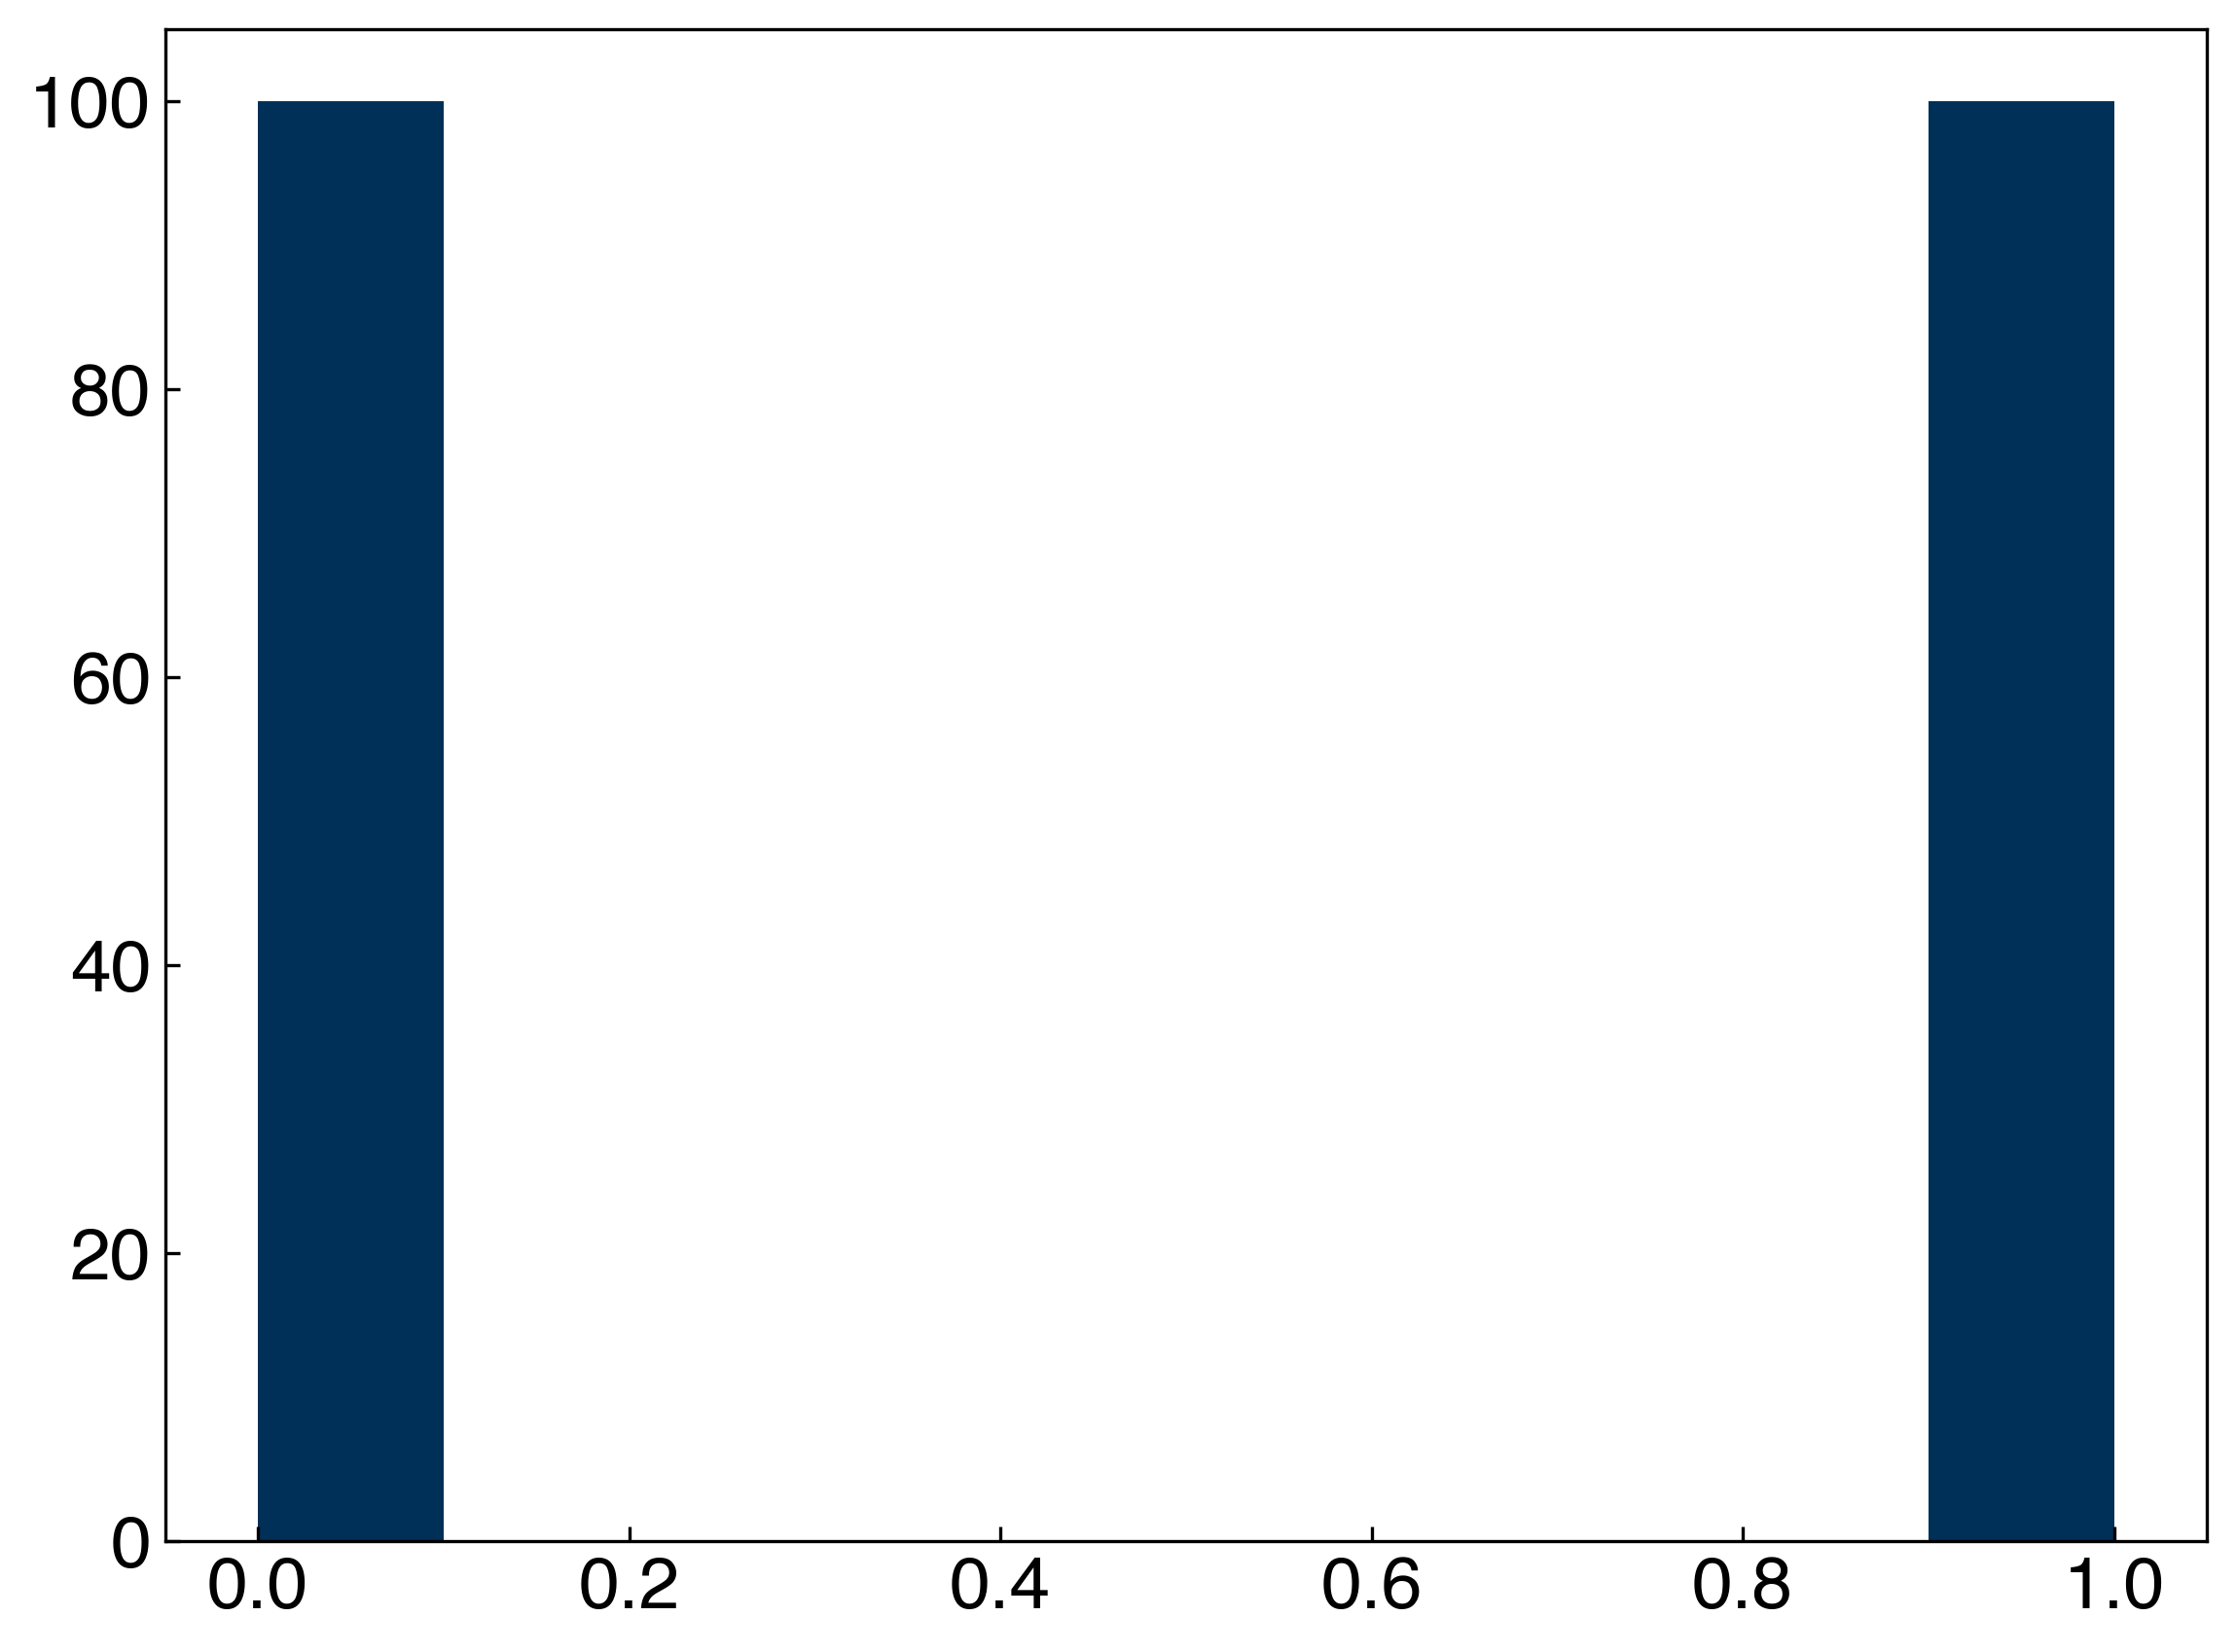

In [4]:
fig, ax = plt.subplots()
ax.hist(y_blob)
plt.show()

### Types Classification Datasets

There are a few different things to consider when examining a classification dataset:

* **Linearly separable**: A problem where it is possible to exactly separate the classes with a straight line (or plane) in the feature space.

```{image} ./linearly_separable.png
:align: center
:width: 400px
```

* **Binary vs. Multi-class**: A binary classification problem has only 2 classes, while a multi-class problem has more than 2 classes. 

There are two approaches to dealing with multi-class problems:

1) Convert multi-class problems to binary problems using a series of "one vs. the rest" binary classifiers

```{image} ./OvA.png
:align: center
:width: 400px
```

2) Consider the multi-class nature of the problem when deriving the method (e.g. kNN) or determining the cost function (e.g. logistic regression)

```{image} ./multiclass_cost.png
:align: center
:width: 400px
```

In the end, the difference between these approaches tend to be relatively minor, although the training procedures can be quite different. One vs. the rest is more efficient for parallel training, while multi-class objective functions are more efficient in serial.

* **Balanced vs. Imbalanced**: A balanced problem has roughly equal numbers of examples in all classes, while an imbalanced problem has an (typically significantly) higher number of examples of some classes. Strategies for overcoming class imbalance will be briefly discussed in subsequent lectures.

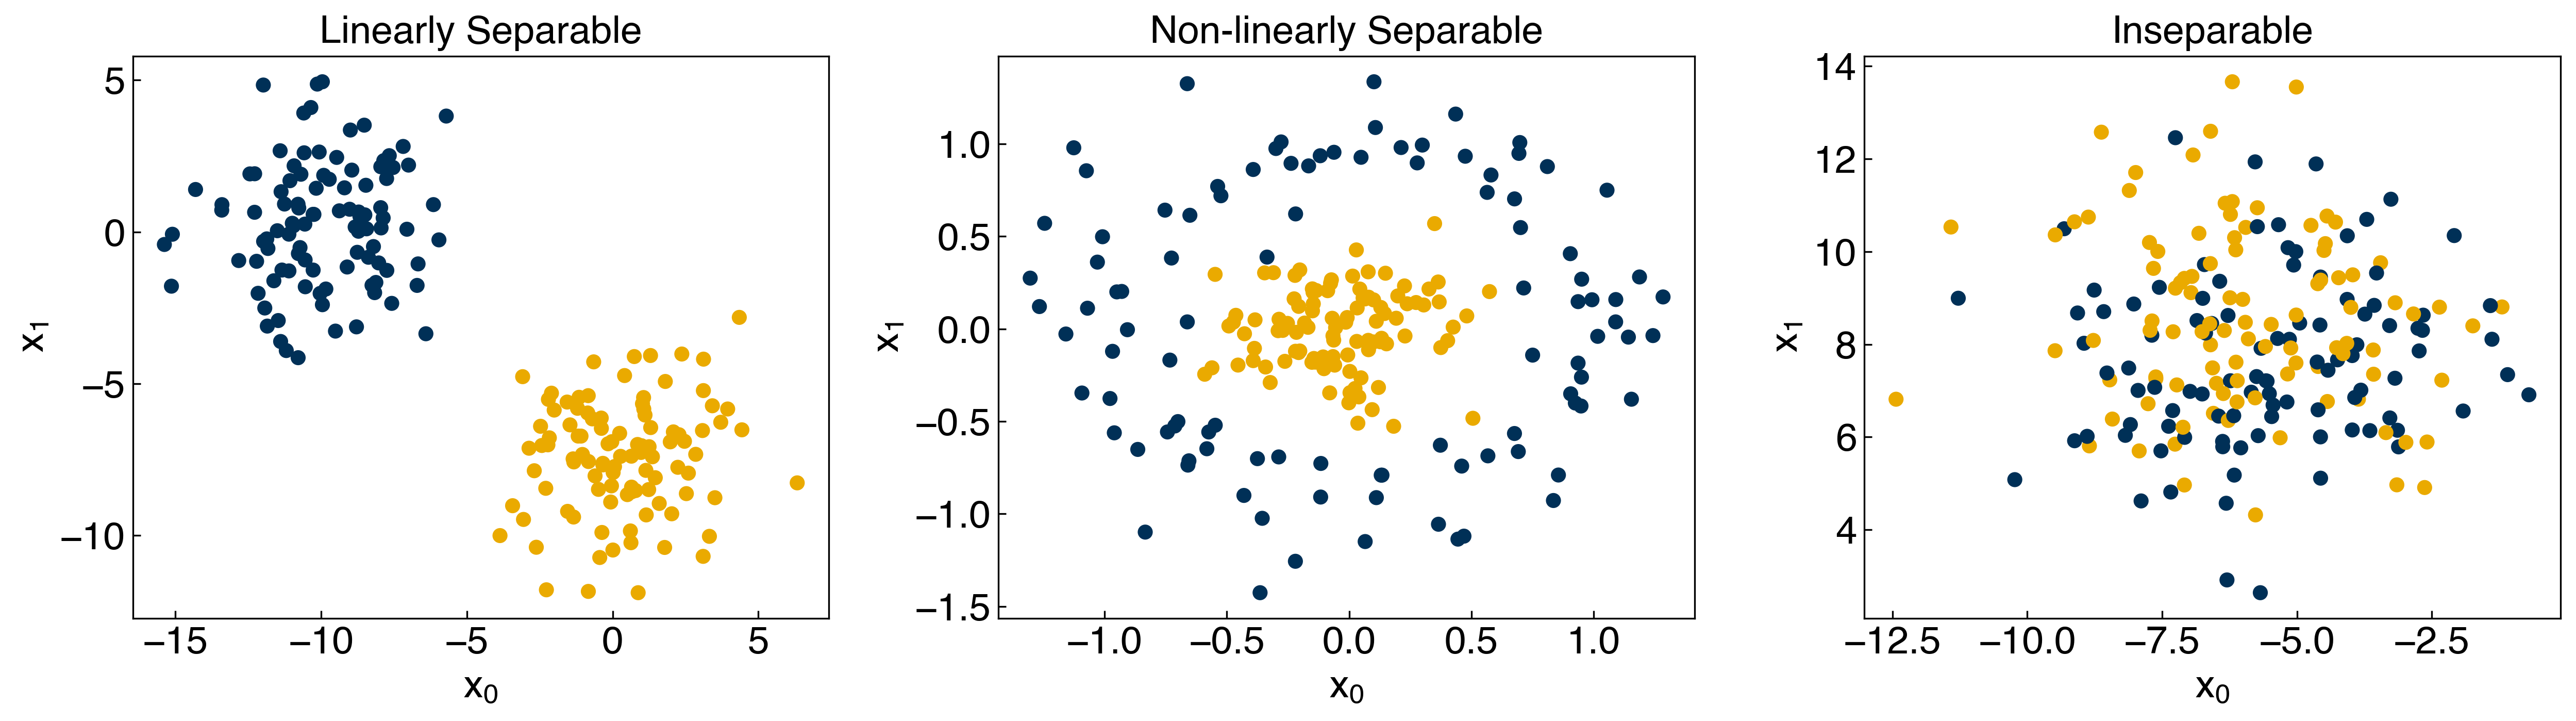

In [5]:
np.random.seed(9)
X_blob1, y_blob1 = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

np.random.seed(5)
X_blob2, y_blob2 = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

X_circles1, y_circles1 = make_circles(n_samples = 200, factor = 0.2, noise = 0.2 * noisiness)

all_datasets = [[X_blob1, y_blob1], [X_circles1, y_circles1], [X_blob2, y_blob2]]

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:,0], Xi[:,1], c = clrs[yi])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')
    
axes[0].set_title('Linearly Separable')
axes[1].set_title('Non-linearly Separable')
axes[2].set_title('Inseparable')
plt.show()

### Discussion: Which of the datasets are:

* Linearly separable?  
> blobs dataset
* Non-linearly separable?  
> moons dataset, circles dataset
* Balanced?  
> all datasets are balanced

### General types of classification models

There are two distinct types of classification models: discriminative and generative. We will focus on discriminative models, but will also discuss and see examples of generative models.

#### Discriminative models:

These models are most similar to regression. Rather than learning a line\model that best represents the data we want to learn a line\model that best separates (discriminates) between different classes. For a binary classifier we can write this as:

$f(\vec{x}) > p$ if class 1

$f(\vec{x}) < p$ if class 2

where $p$ is some constant threshold that separates the classes.

Another way to think of this is that we will establish a function that estimates the probability of a point belonging to a particular class, given its features:

$P(y_i|\vec{x}) = f(\vec{x})$

Then the classes can be discretized by establishing probability cutoffs. Conceptually, discriminative models separate classes by identifying **differences** between classes, and directly solve the problem of estimating class probability.

#### Generative models

Generative models are somewhat less intuitive, but can be very powerful. In a generative model the goal is to solve the "inverse problem" of predicting the probability of features given a class label output. Conceptually, you can think of this as identifying **similarities** between points within a given class. Mathematically:

$P(\vec{x}|y_i) = f(\vec{x})$

This is counter-intuitive, but the model can then be used in conjunction with Bayes' rule to indirectly solve the classification problem. Bayes rule is:

$P(A|B) = \frac{P(B|A) P(A)}{P(B)} \rightarrow P(y_i|\vec{x}) = \frac{P(\vec{x}|y_i) P(y_i)}{P(\vec{x})}$

The $P(y_i)$ term is available from the data (number of times each class appears) and the $P(\vec{x})$ term is a constant so it can be dropped when computing relative probabilities.

Generative models are more difficult to understand, but they have a key advantage: new synthetic data can be generated by using the function $P(\vec{x}|y_i)$. This opens the possibility of iterative training schemes that systematically improve the estimate of $P(\vec{x}|y_i)$ (e.g. Generative Artificial Neural Networks) and can also aid in diagnosing problems in models.


```{image} ./discriminative_vs_generative.png
:align: center
:width: 800px
```

## Accuracy metrics and model validation

Assessing the accuracy of a classification model requires different metrics from regression. We will explore a few here.

### False positives and false negatives
Since the output of a classification problem is discrete, we can have different types of errors. In particular, there are 2 types of errors for any 2-class problem:

* False positives (Type I error): A point is classified as 1 but should be 0.
* False negatives (Type II error): A point is classified as 0 but should be 1.

Note that in most problems we will work with the definition of 0 and 1 is arbitrary, so these types can be arbitrarily switched. However, they are still distinctly different kinds of failures of the model, and in some cases it can make a big difference.

### Discussion: Consider a chemical process where your model is predicting whether or not a reactor is near runaway conditions. What are the implications of a false positive or negative?

### Accuracy, Precision, Recall, and F1 scores

The accuracy, precision, and recall are 3 common metrics for evaluating 2-class models:

* Accuracy = (number correct)/(total) = (TP + TN)/(TP + TN + FP + FN)
* Precision = TP/(TP + FP)
* Recall = TP/(TP + FN)

An additional metric, the F1 score, is sometimes used to summarize precision and recall:

* F1 = $\frac{2 Precision \times Recall}{Precision + Recall}$

This is the "harmonic mean" of precision and recall and ranges from 0 for a model with 0 precision or recall to 1 for a model with perfec precision and recall.

```{image} ./precision_recall.png
:align: center
:width: 500px
```

We can implement this with a simple Python function:

In [6]:
def acc_prec_recall(y_model, y_actual):
    TP = np.sum(np.logical_and(y_model == y_actual, y_model == 1))
    TN = np.sum(np.logical_and(y_model == y_actual, y_model == 0))
    FP = np.sum(np.logical_and(y_model != y_actual, y_model == 1))
    FN = np.sum(np.logical_and(y_model != y_actual, y_model == 0))
    acc = (TP + TN) / (TP + TN + FP + FN)
    if TP == 0:
        prec = 0
        recall = 0
    else:
        prec = TP / (TP + FP)
        recall = TP / (TP + FN)
    return acc, prec, recall

These metrics depend strongly on the class imbalance! Let's take one of our toy datasets and create a truly bad classifier that always guesses that the class is 0. Then, we can see how the accuracy, precision, and recall of this classifier change as the imbalance shifts:

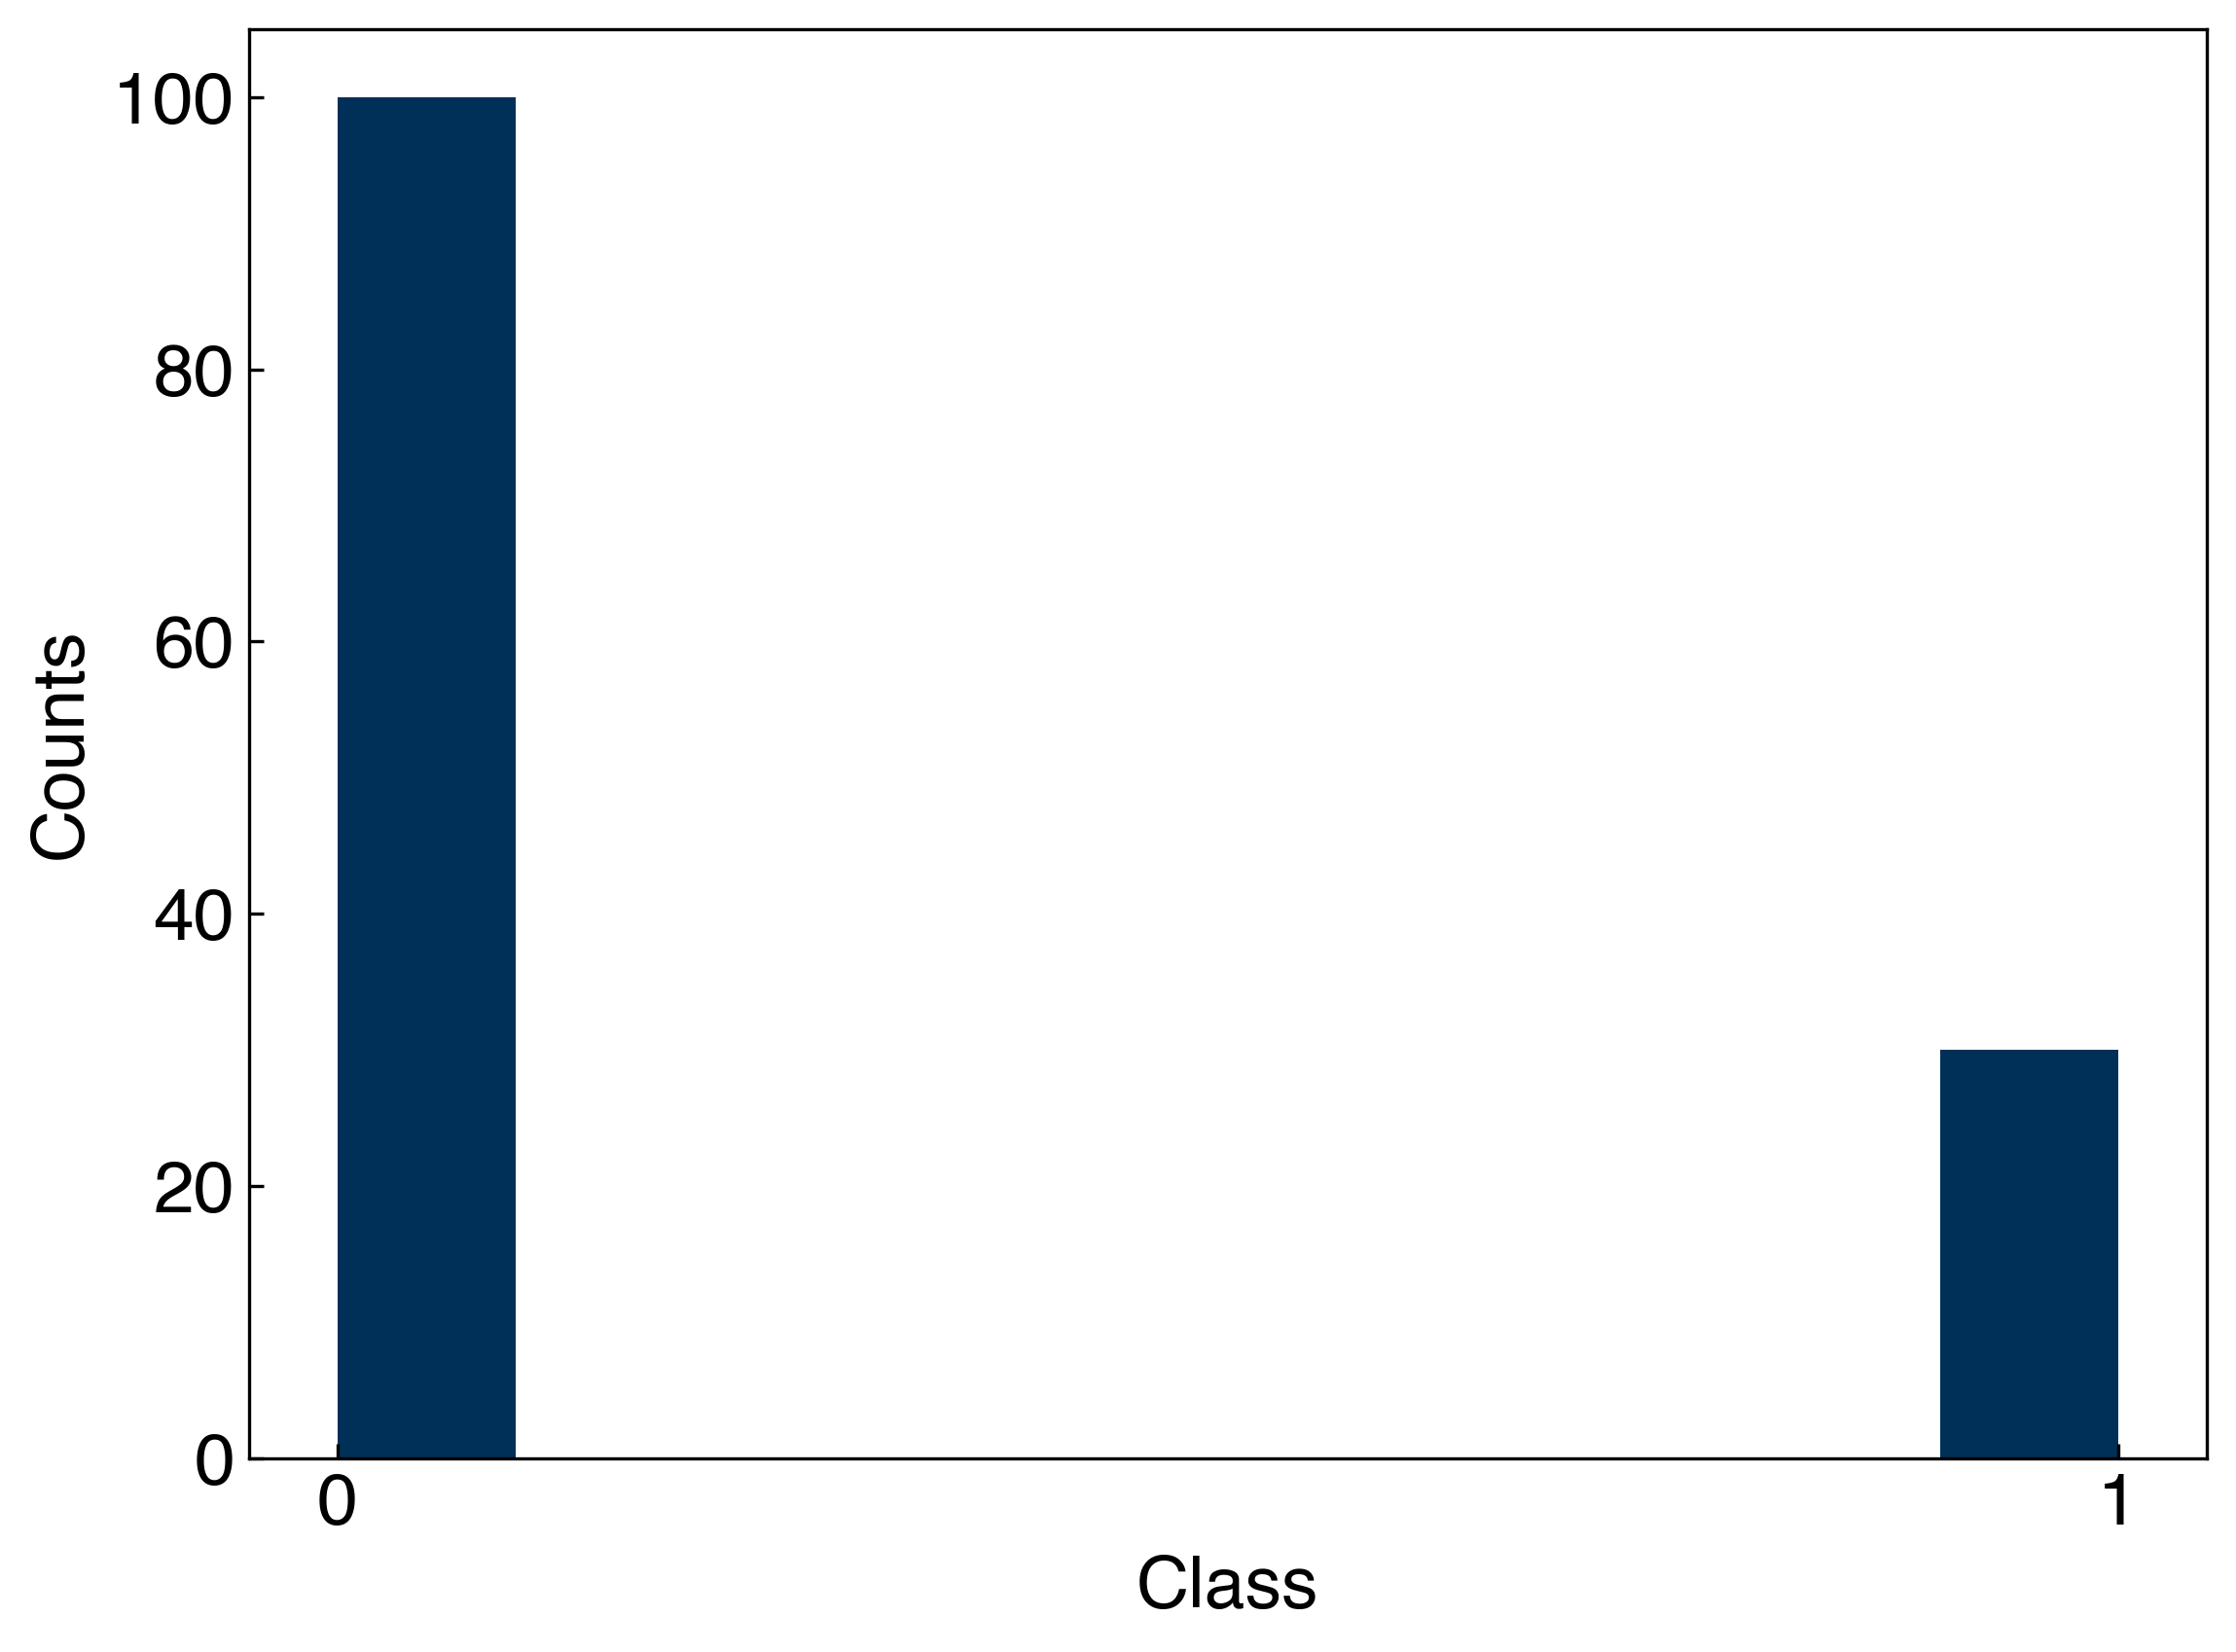

In [7]:
N_include = 30

#only include N_include examples of class 1
y_imbalanced = []
Ni = 0
for i, yi in enumerate(y_moons):
    if yi == 1 and Ni < N_include:
        y_imbalanced.append(yi)
        Ni += 1
    elif yi == 0:
        y_imbalanced.append(yi)

y_imbalanced = np.array(y_imbalanced)
fig, ax = plt.subplots()
ax.hist(y_imbalanced)
ax.set_xticks([0, 1])
ax.set_xlabel('Class')
ax.set_ylabel('Counts');

Now we can calculate the accuracy, precision, and recall when our classifier simply guesses that every point is 0:

In [8]:
y_guess = np.zeros(len(y_imbalanced))

acc_prec_recall(y_guess, y_imbalanced)

(0.7692307692307693, 0, 0)

### Receiver Operating Characteristic (ROC) curves 

The "receiver operating characteristic", or ROC curve, is useful for models where a threshold is used to tune the rate of false positives and false negatives. The area under the curve can be used as a metric for how well the model performs.

```{image} ./ROC_curve.jpg
:align: center
:width: 300px
```

We will discuss this metric more once the meaning of a "threshold" has been described.

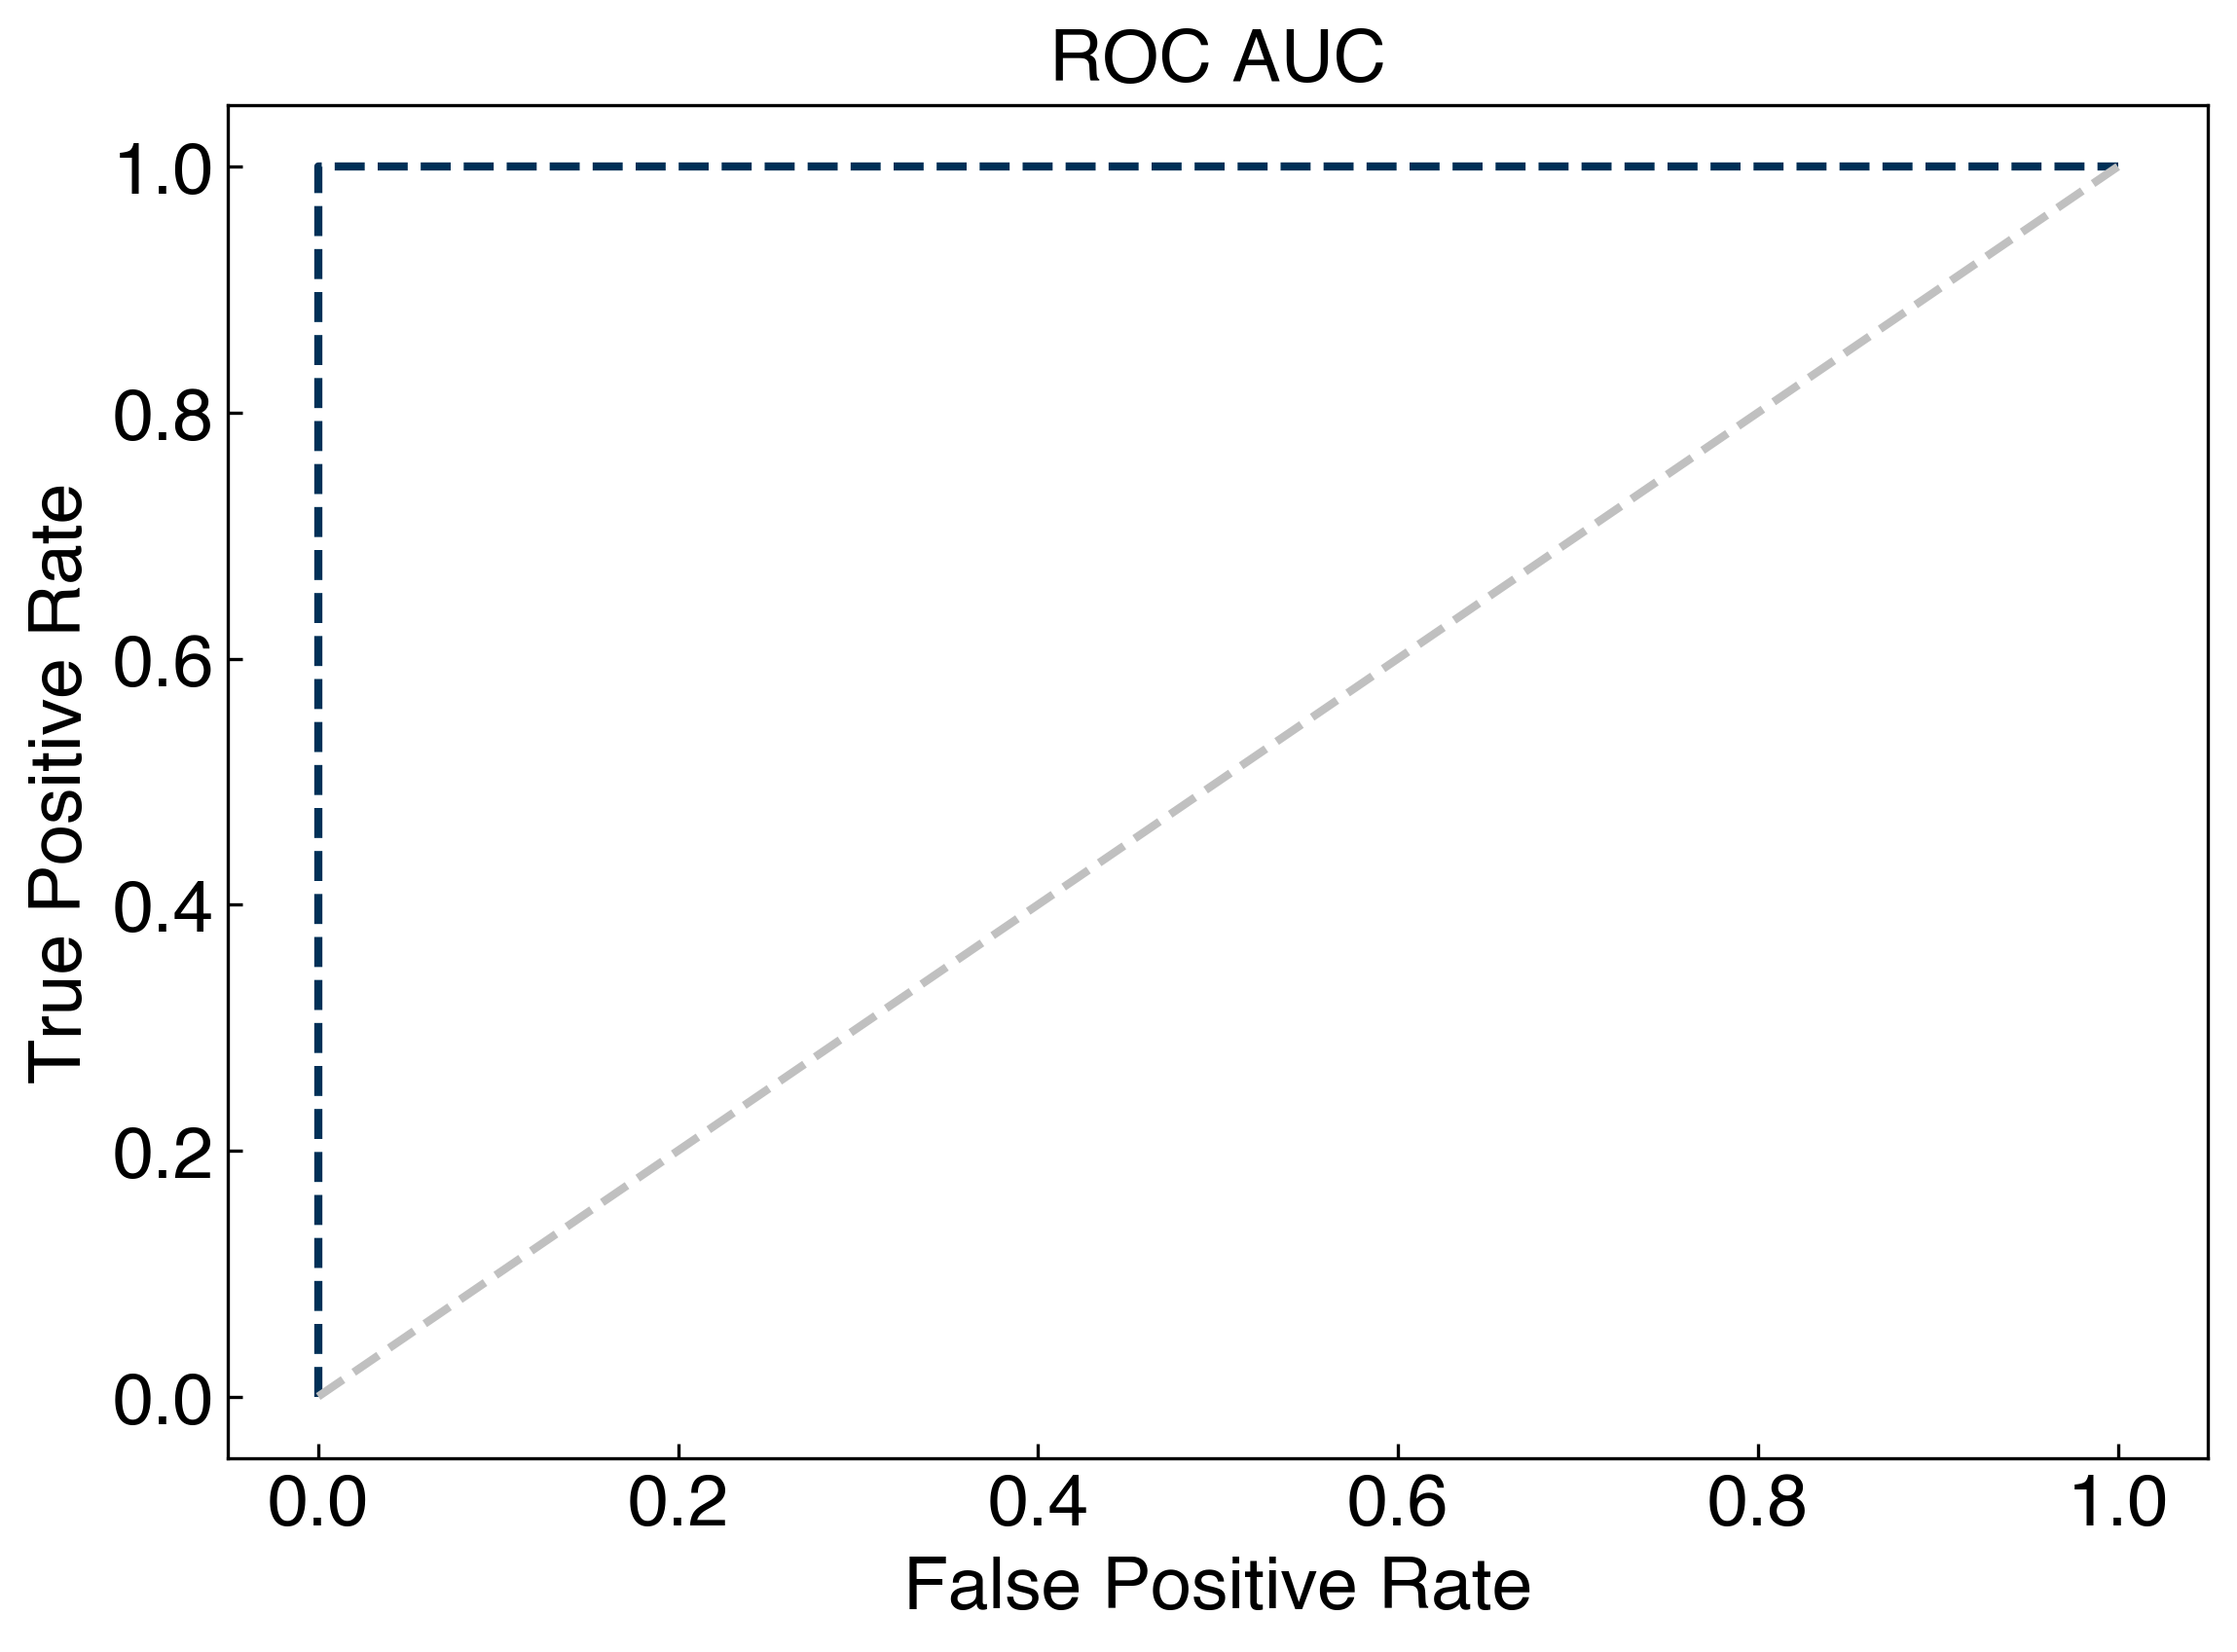

In [9]:
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

svc = SVC()
sgd = SGDClassifier()
rf = RandomForestClassifier()

sgd.fit(X_blob2, y_blob2)
y_sgd = sgd.predict(X_blob2)

rf.fit(X_blob2, y_blob2)
y_rf = rf.predict(X_blob2)

fpr, tpr, threshold = roc_curve(y_blob2, y_rf)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot(fpr, fpr, '#C0C0C0')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC AUC');

### Confusion matrices

False positives and false negatives only apply to binary problems. The "confusion matrix" is a multi-class generalization of the concept, and can help identify which classes are "confusing" the algorithm.

```{image} ./confusion_matrix.png
:width: 500px
:align: center
```

In a confusion matrix the diagonal elements correspond to true positives and true negatives, while the off-diagonal elements correspond to false postives and false negatives, with false positives above the diagonal and false negatives below (or vice versa, depending on label definitions).

### Cross-validation and Resampling

Similar to the case of regression, cross-validation is an important tool for classification models. The general idea is the same: We hide some of the data from the model when we train it, then we test the model on the hidden data.

However, there are a few wrinkles in classification that arise in the case of class imbalance. When constructing test/train sets, it is important to ensure that all classes are represented in a manner consistent with the overall set. This can be a major challenge if the classes are highly imbalanced. The best approach is to balance classes prior to cross validation. There are a few strategies for doing this:

1) Re-balancing the cost function to penalize mis-classification of the under-represented class more. This works well, but requires that you know the relative importance of the 2 classes, and requires modifying the inner working of the algorithms. It also suffers from some of the same disadvantages as over-sampling.

2) Undersampling: discarding information from over-represented class. This is inefficient since not all information is used.

```{image} ./class_imbalance.png
:width: 500px
:align: center
```

3) Oversampling: add repeates of the under-represented class (very similar to re-balancing the cost function). This can lead to over-fitting of the decision boundary to the few examples of the under-represented class.

```{image} ./oversampling.png
:width: 500px
:align: center
```

4) Resampling: Re-sample from the under-represented class, but add some noise. This is a robust solution, but requires some knowledge of the distribution of the under-represented data (e.g. generative models) or special techniques (e.g. SMOTE).

```{image} ./smote.png
:width: 500px
:align: center
```

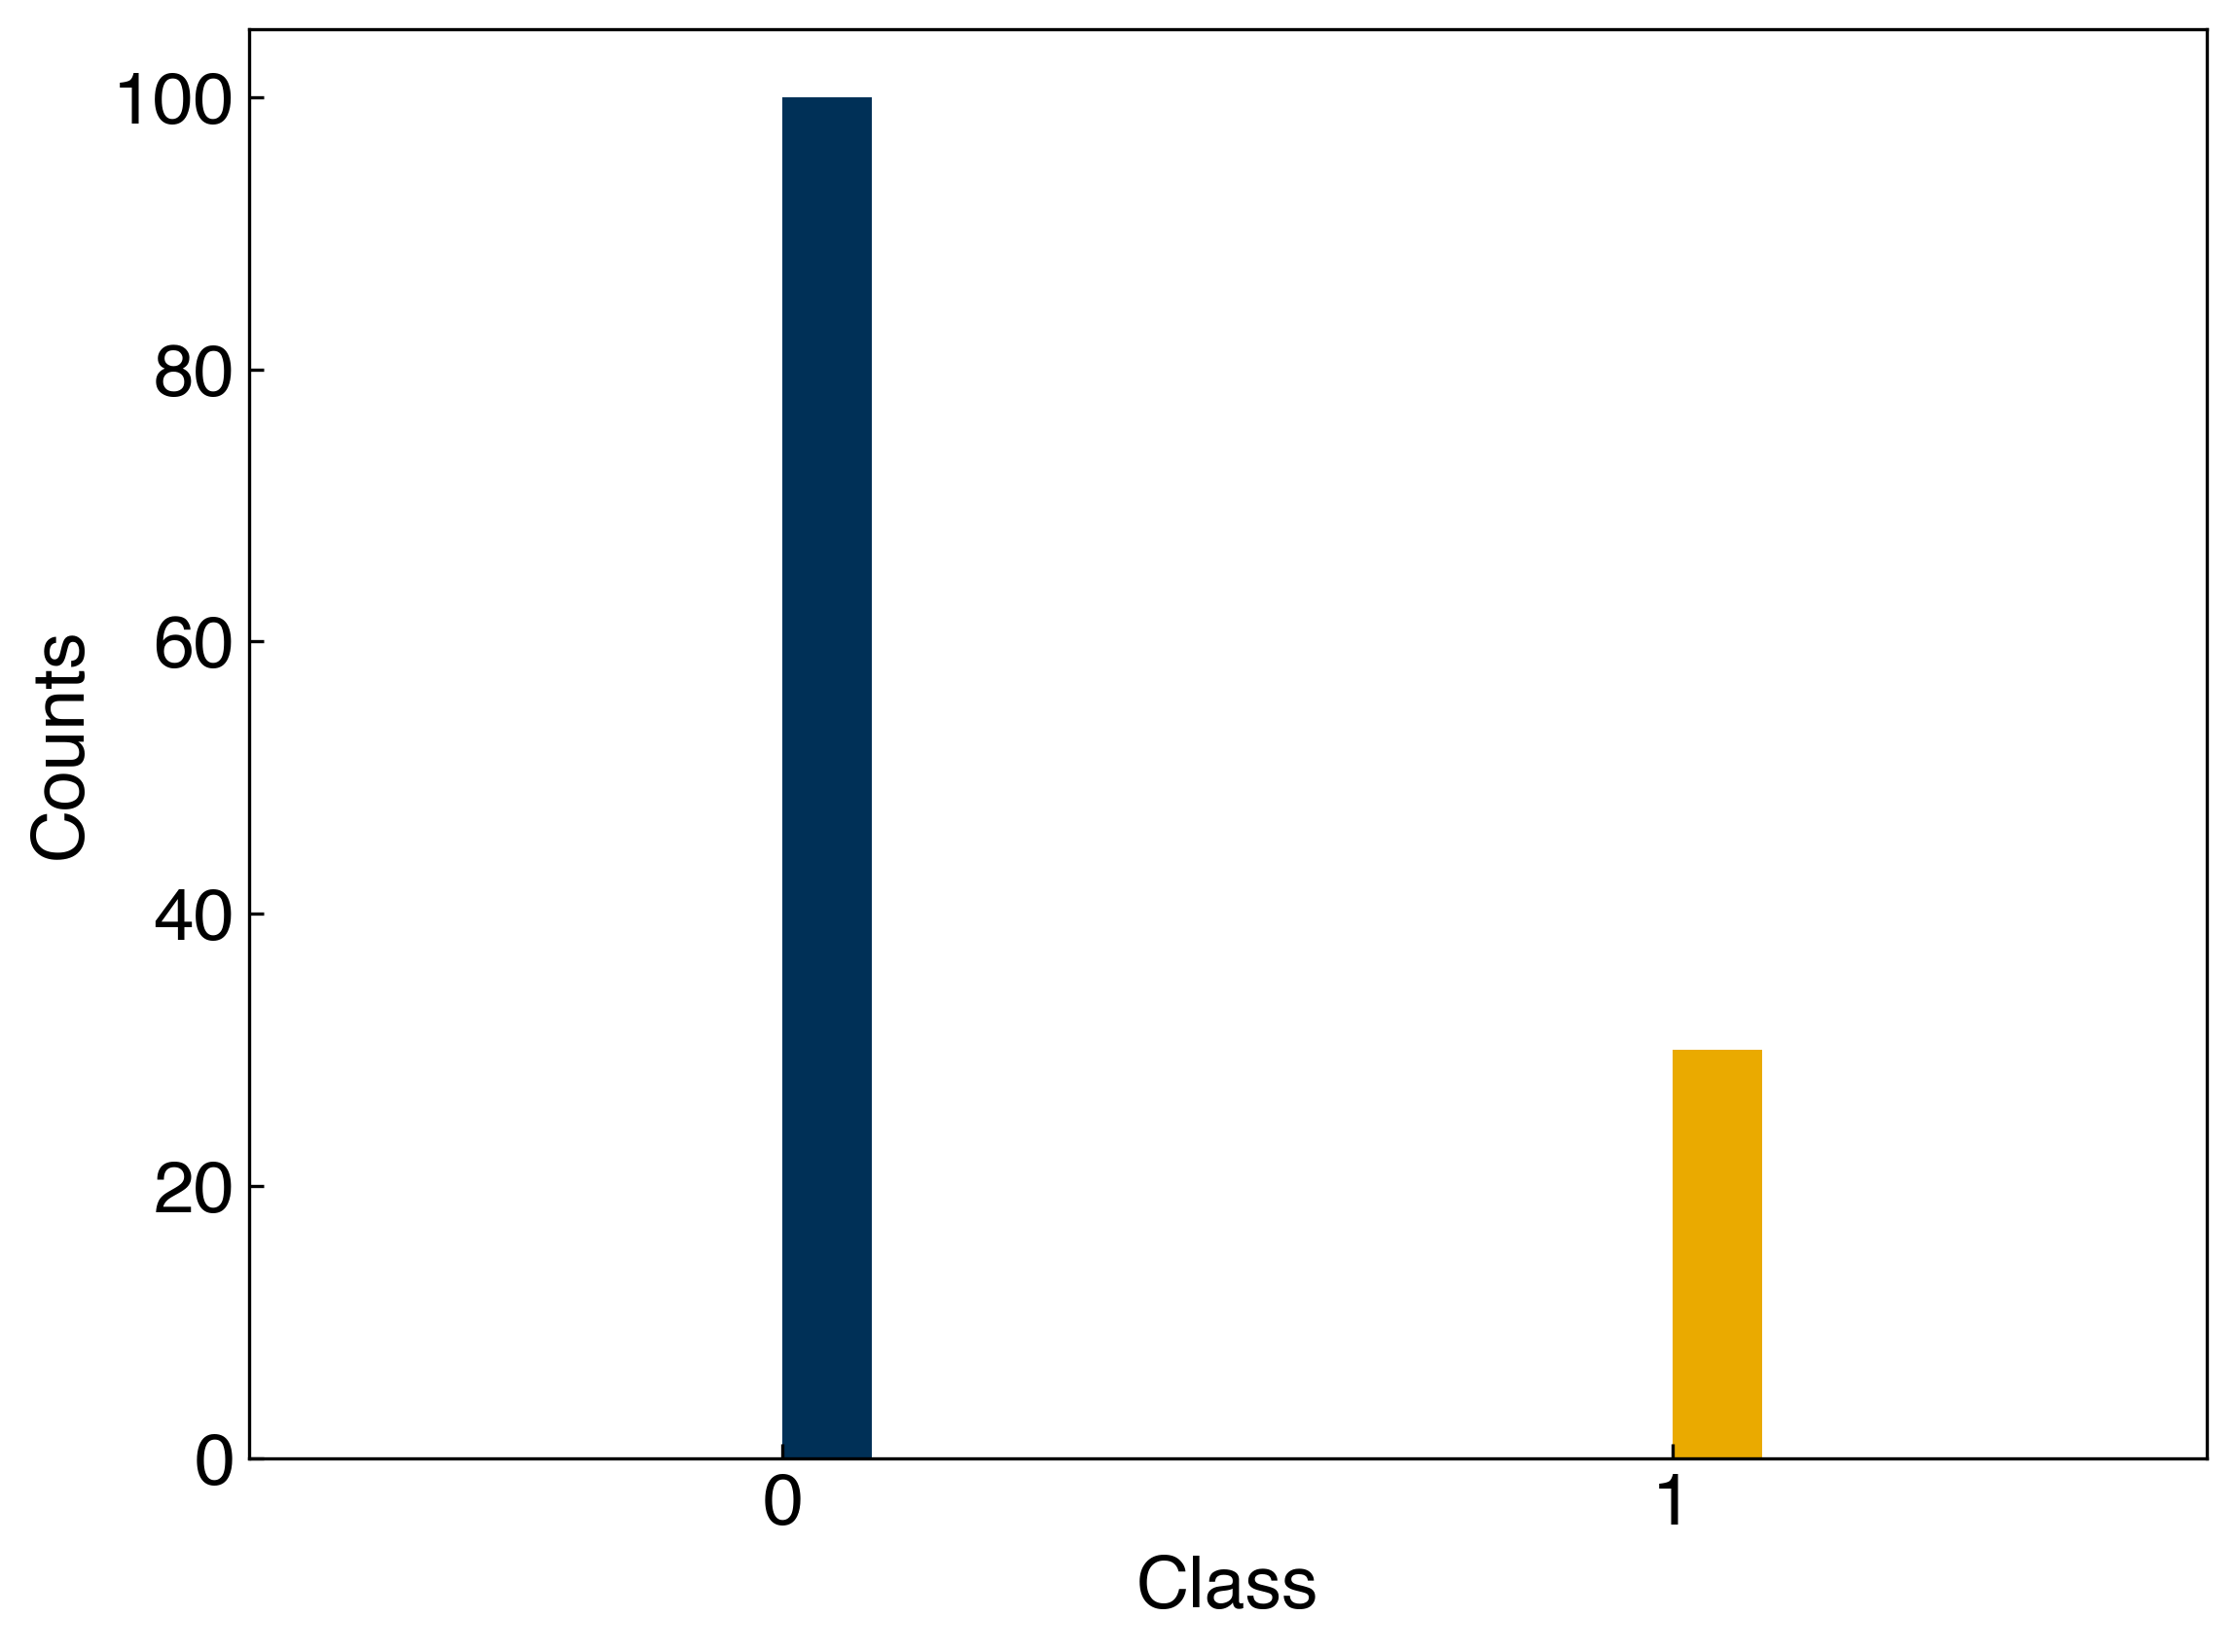

In [10]:
fig, ax = plt.subplots()

ax.hist(y_imbalanced[y_imbalanced == 0])
ax.hist(y_imbalanced[y_imbalanced == 1])
ax.set_xticks([0, 1])
ax.set_xlabel('Class')
ax.set_ylabel('Counts');

## Multi-class classification

In [11]:
np.random.seed(9)
X_blob1, y_blob1 = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

np.random.seed(248)
X_blob3, y_blob3 = make_blobs(n_samples = 200, centers = 3, cluster_std = .6 * noisiness, n_features = 2)

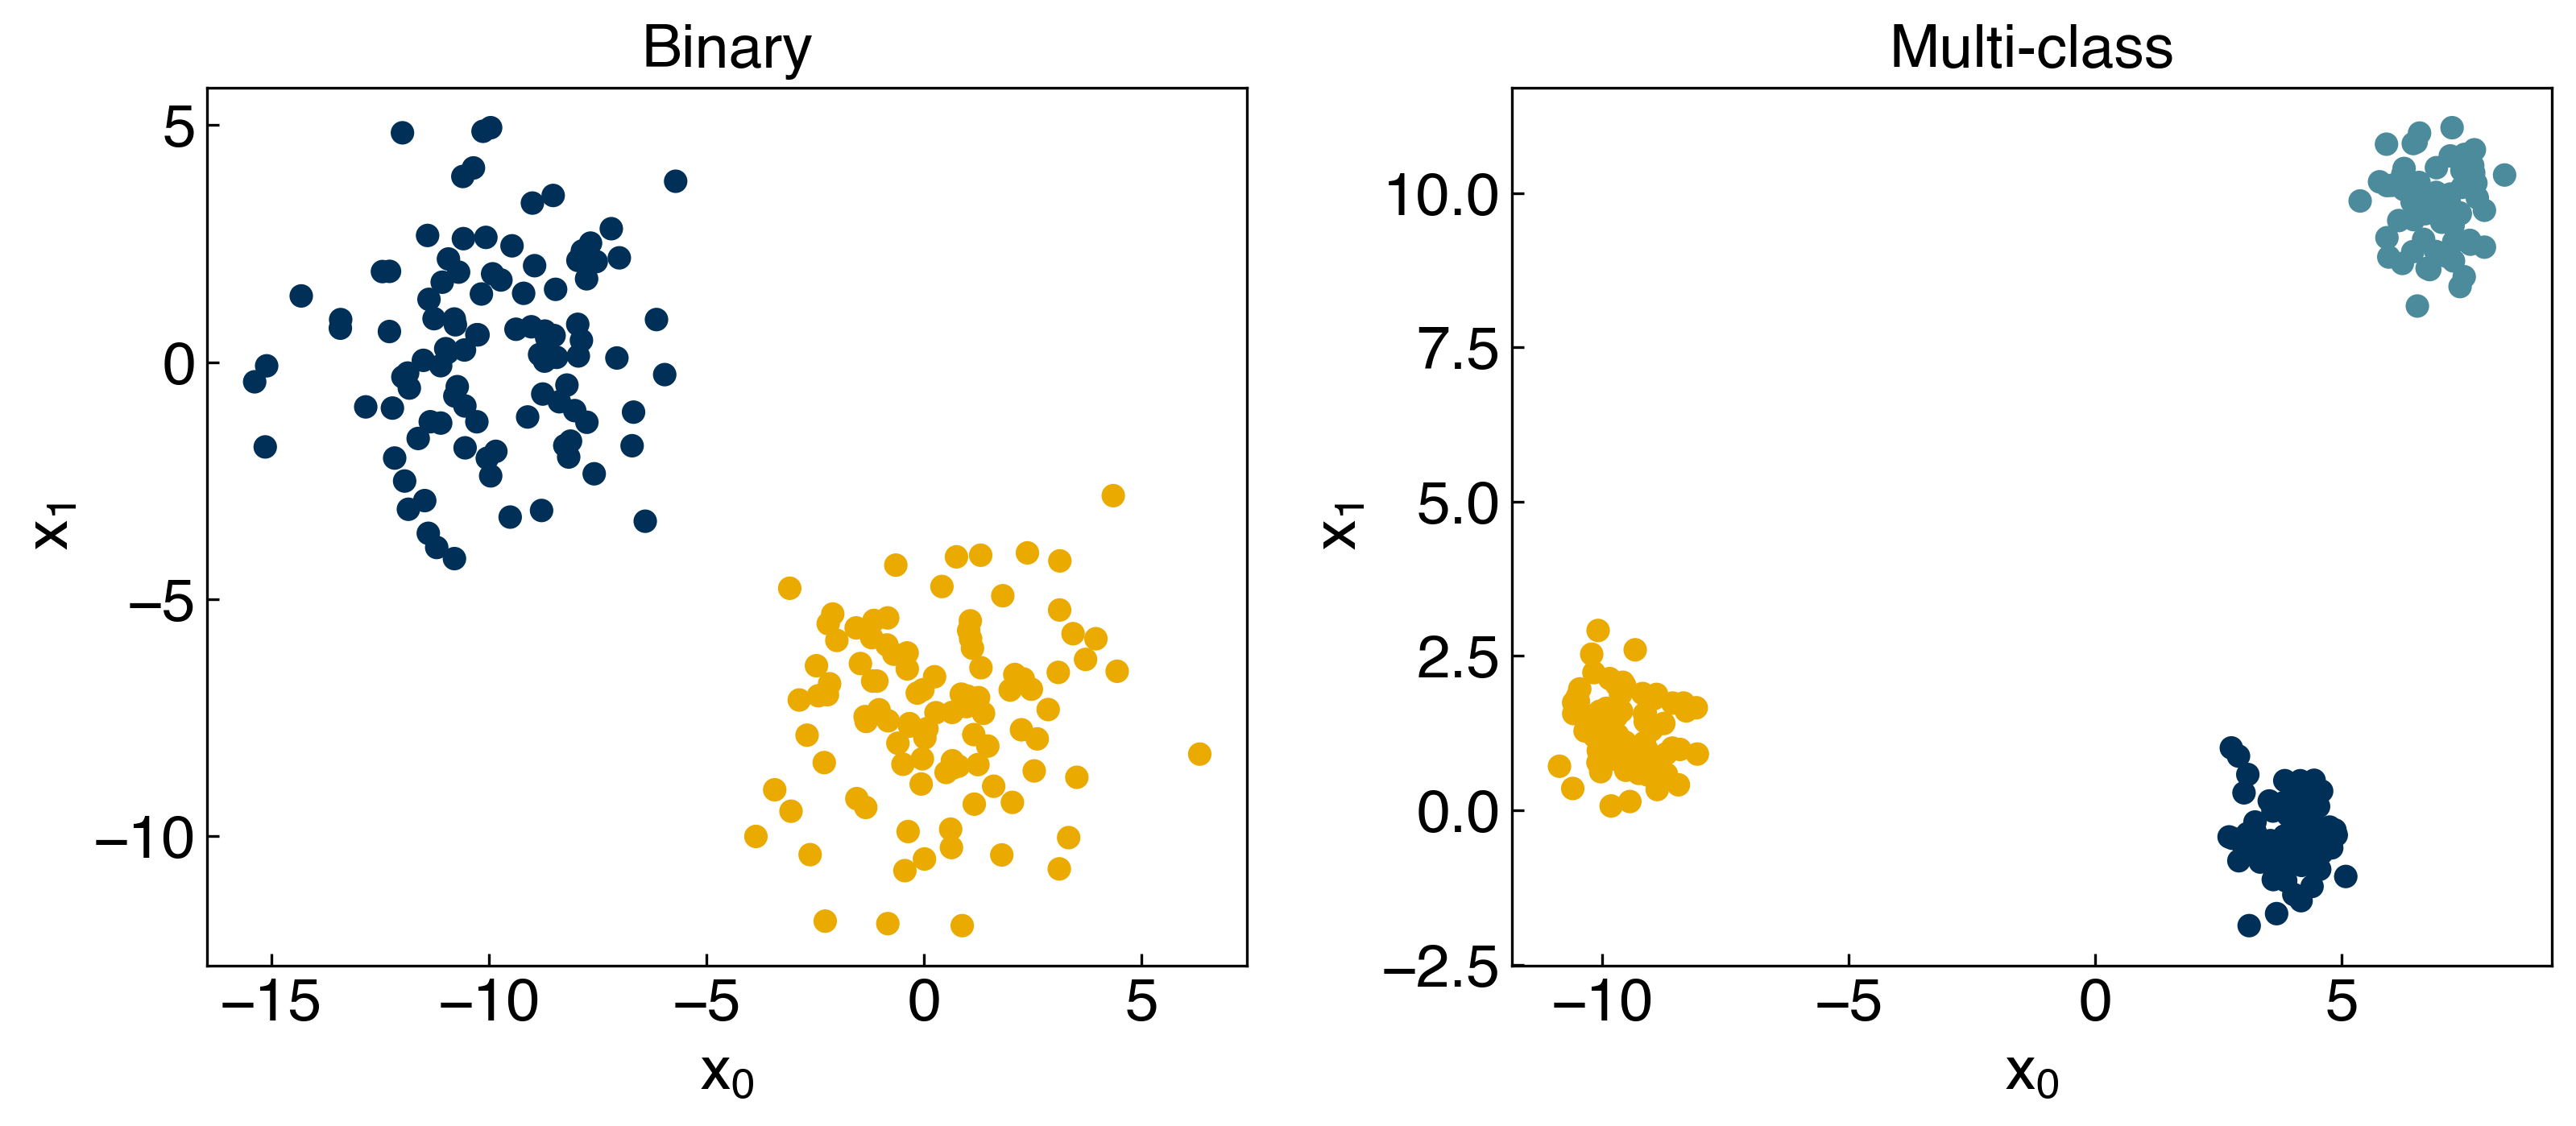

In [12]:
all_datasets = [[X_blob1, y_blob1], [X_blob3, y_blob3]]
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:,0], Xi[:,1], c = clrs[yi])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')
    
axes[0].set_title('Binary')
axes[1].set_title('Multi-class')
plt.show()

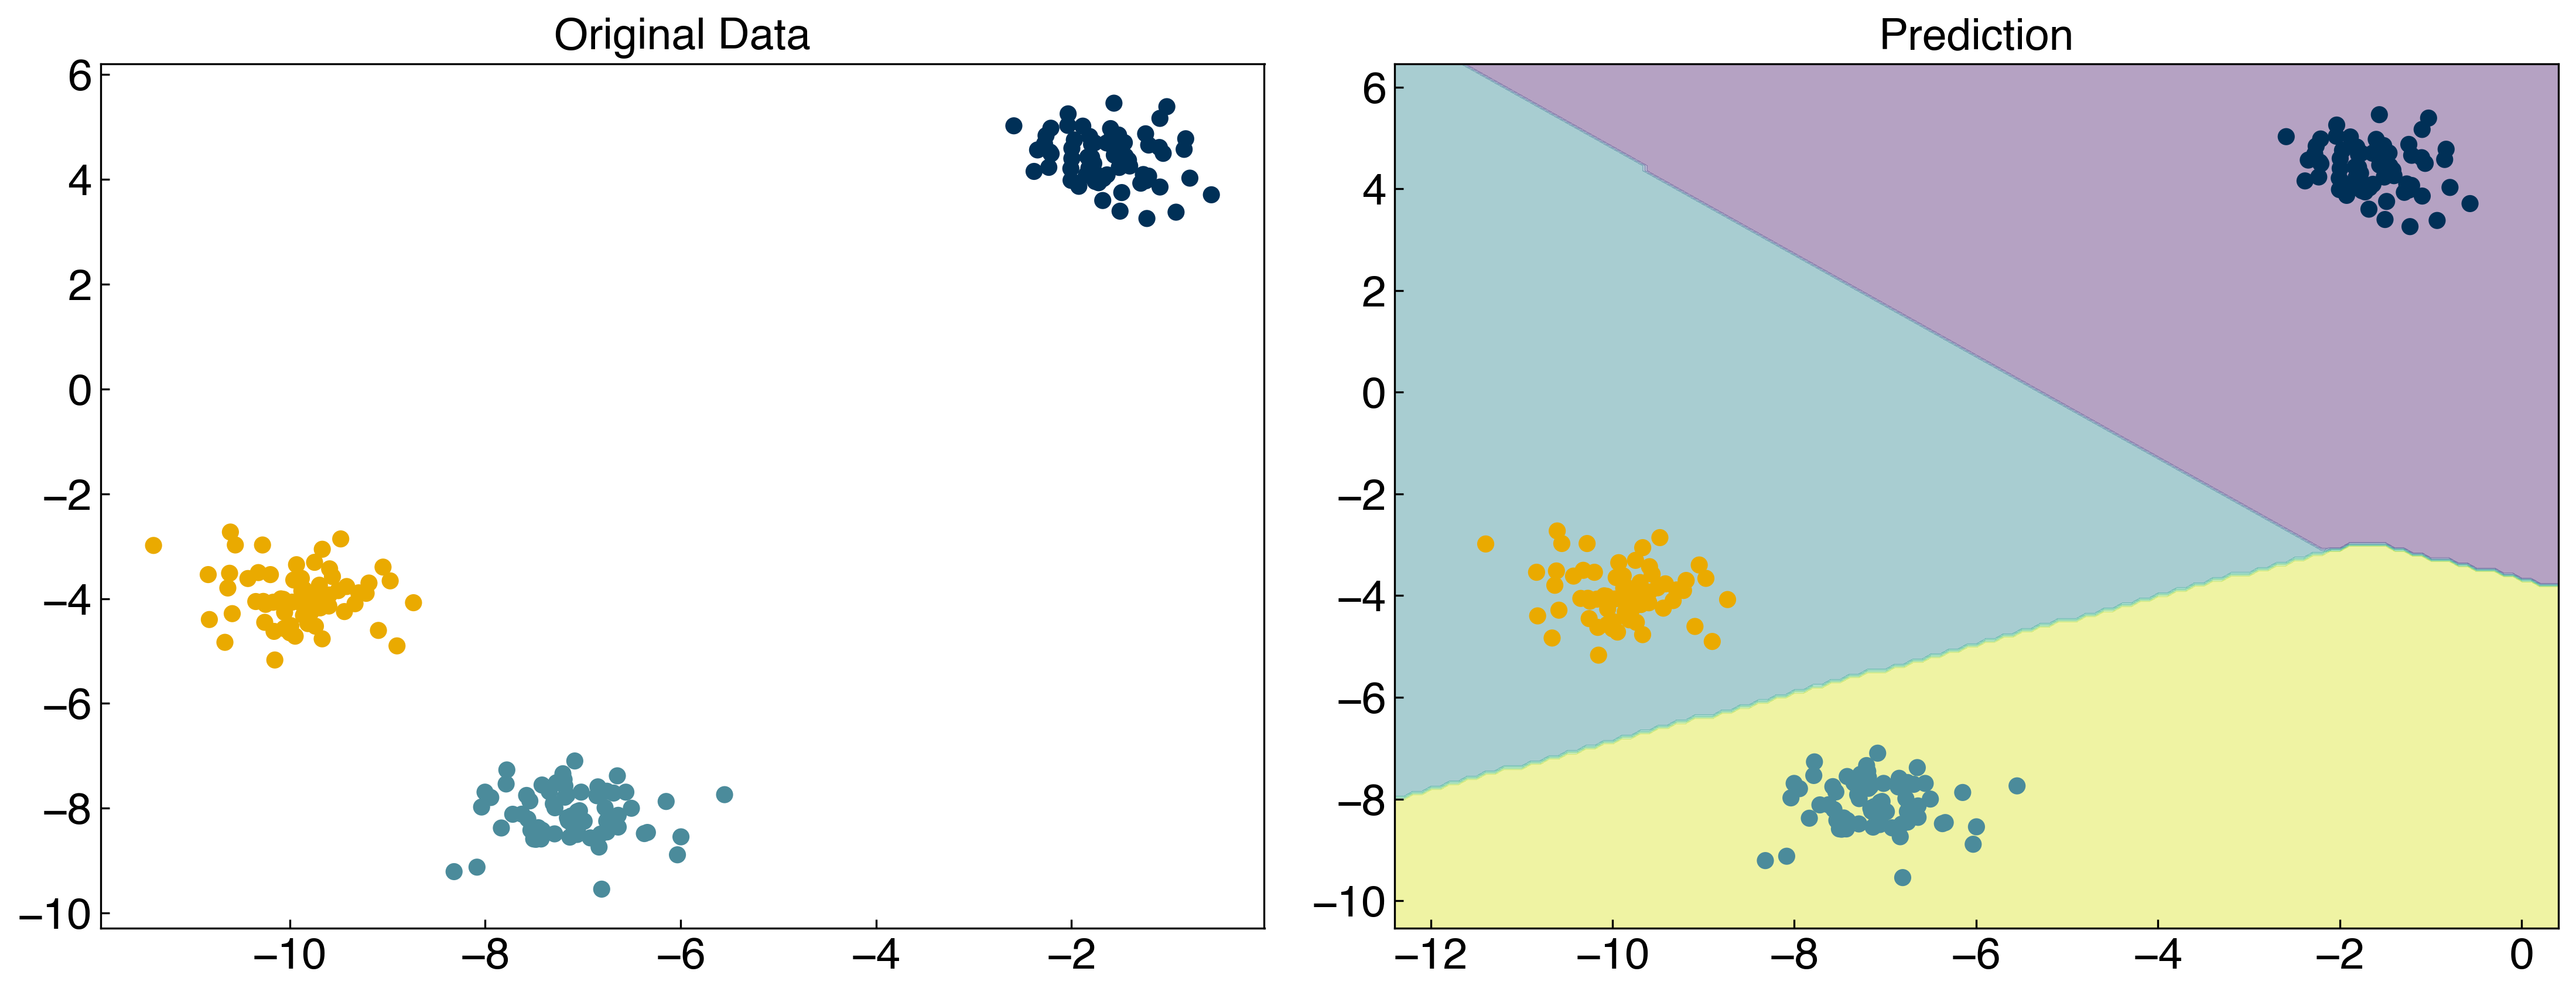

In [13]:
np.random.seed(1)
X_mc, y_mc = make_blobs(n_samples = 200, centers = 3, cluster_std = 0.5*noisiness, n_features = 2)

model = SVC(kernel = 'linear', C = 1, decision_function_shape = 'ovr')

model.fit(X_mc, y_mc)
y_mc_hat = model.predict(X_mc)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_mc[:, 0], X_mc[:, 1], c = clrs[y_mc])

x_min, x_max = X_mc[:, 0].min() - 1, X_mc[:, 0].max() + 1
y_min, y_max = X_mc[:, 1].min() - 1, X_mc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1].contourf(xx, yy, Z, alpha = 0.4)
axes[1].scatter(X_mc[:, 0], X_mc[:, 1], c = clrs[y_mc_hat])
axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

## Deriving a loss function for discrimination

So far we have not actually discussed how to create a classification model. We will start by investigating discriminative models, since these are most similar to regression. The difference is that instead of regressing a line that fits the input data, we are regressing a line that discriminates between the two classes. This requires a new loss function. We can derive one such loss function by considering the following mathematical definition of a classification model.

We will start by considering a discrimination problem:

$f(\vec{x}) > p$ if class 1

$f(\vec{x}) < p$ if class 2

and let $f(\vec{x}) = \bar{\bar{X}}\vec{w}$, where $\bar{\bar{X}} = [\vec{x}, \vec{1}]$ similar to linear regression.

We can use $y$ as the output variable and arbitrarily assign "class 1" to 1 and "class 2" to -1, such that $p = 0$.

$\bar{\bar{X}}\vec{w} > 0$ if $y_i=1$ (class 1)

$\bar{\bar{X}}\vec{w} < 0$ if $y_i=-1$ (class 2)

Let's take a look at this in code with some toy data:

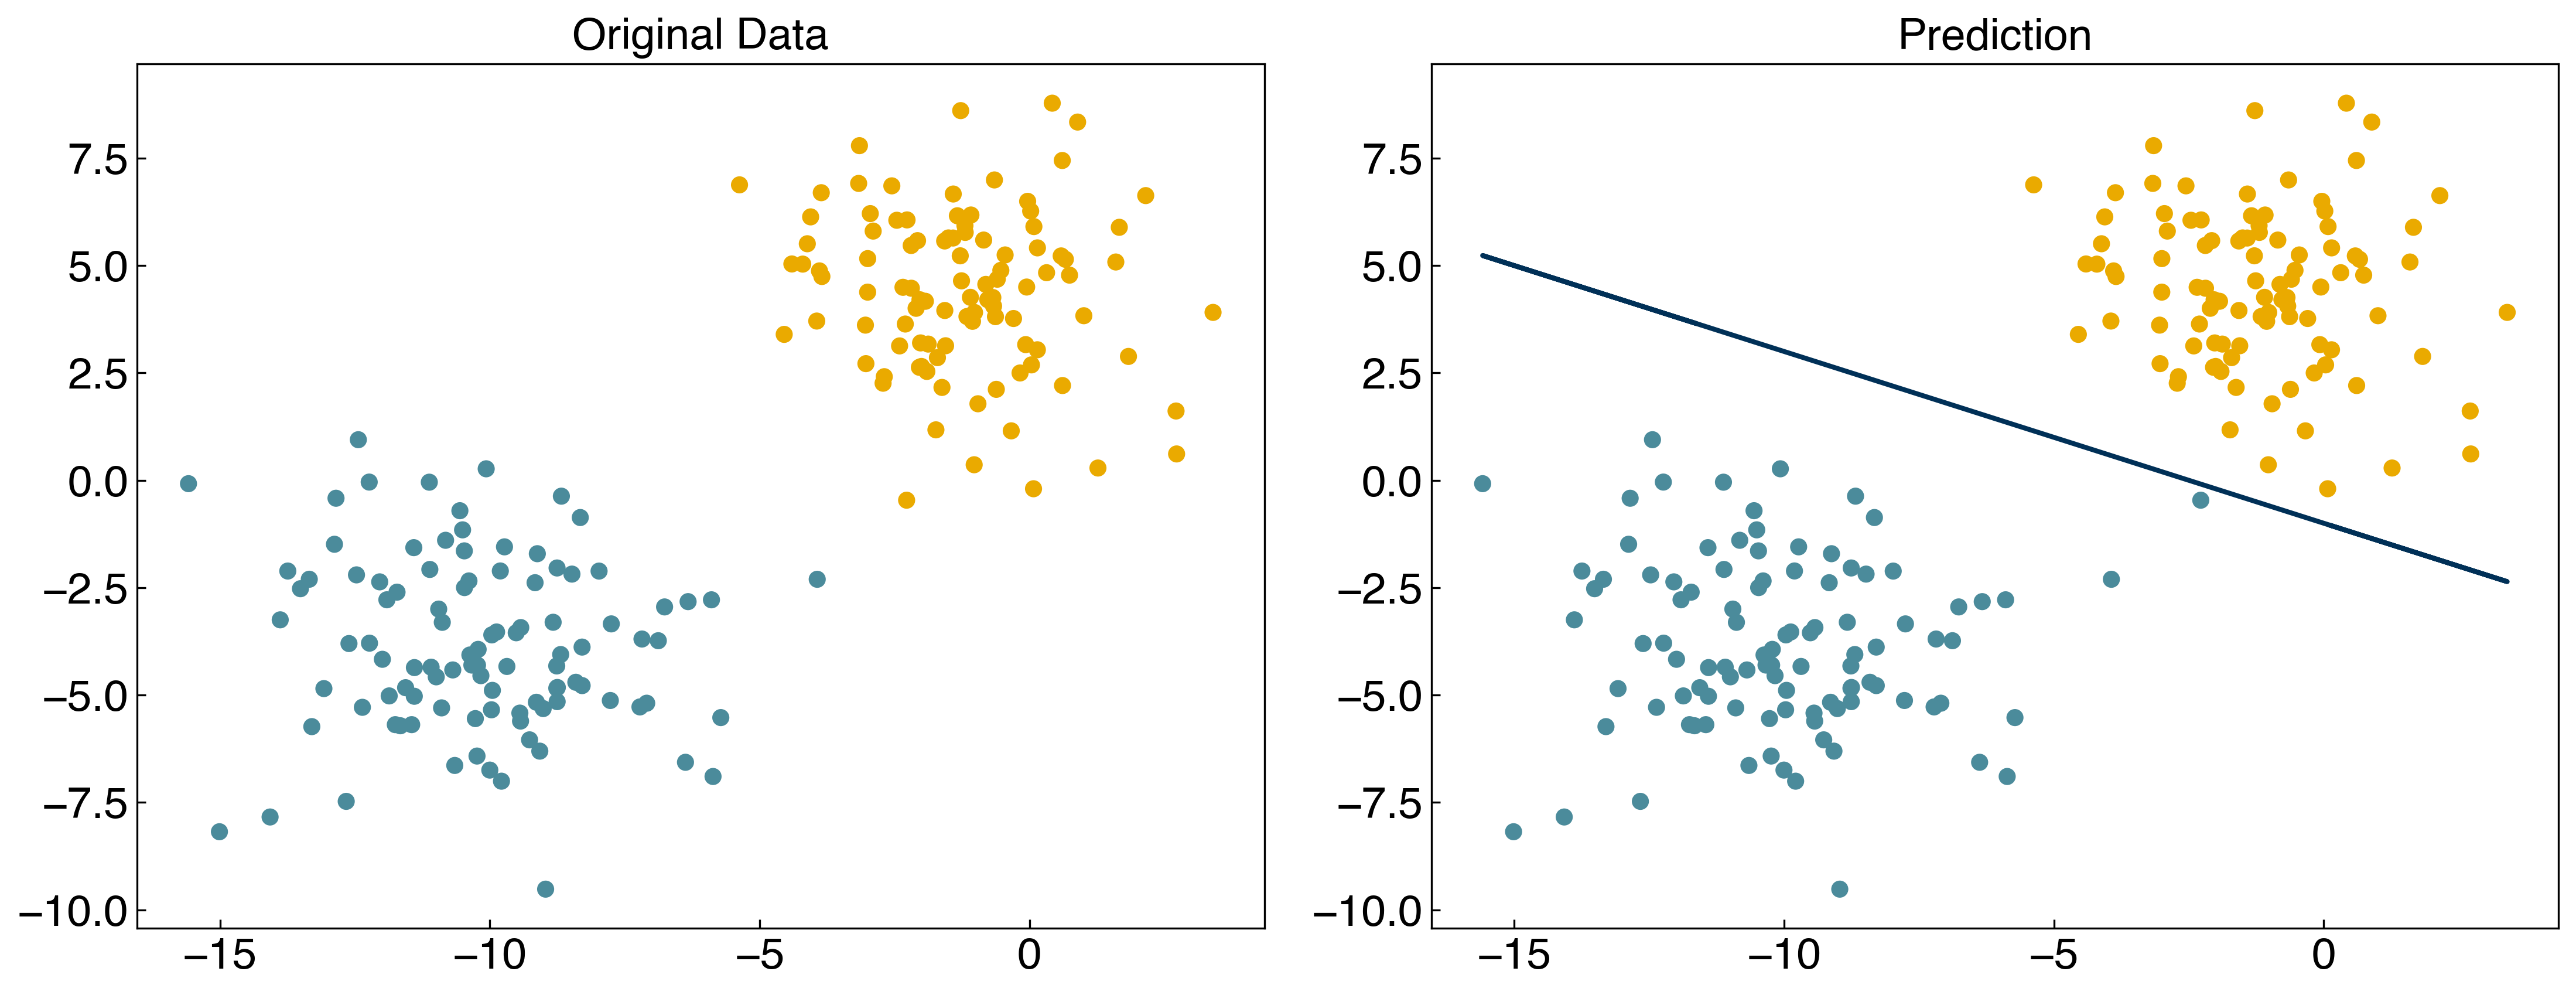

In [14]:
def add_intercept(X):
    intercept = np.ones((X.shape[0],1))
    X_intercept = np.append(intercept,X,1)
    return X_intercept

def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return p > 0

X = X_blob
y = y_blob
y = y_blob*2 - 1 #convert to -1, 1

w = np.array([-10, -4, -10])
prediction = linear_classifier(X, w)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w[1] / w[2]
b = -w[0] / w[2]
axes[1].plot(X[:, 0], m*X[:, 0]+b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

### Example: Derive the slope and intercept of the line that discriminates between the two classes.

Consider a model of the form:

> $\bar{\bar{X}}\vec{w} > 0$ if $y_i=1$ (class 1)

> $\bar{\bar{X}}\vec{w} < 0$ if $y_i=-1$ (class 2)

> where $\bar{\bar{X}} = [\vec{x_0}, \vec{x_1}, \vec{1}]$ and $\vec{w} = [w_0, w_1, w_2]$.

Then, the equation will be

> $x_0w_0 + x_1w_1 + w_2 = 0$

> $x_1 = -\frac{w_0}{w_1}x_0 - \frac{w_2}{w_1}$

The slope will be $-\frac{w_0}{w_1}$ and the intercept will be $-\frac{w_2}{w_1}$.

This looks a lot like linear regression, but we still need an **objective function**. This is where things get tricky. Based on the definition of $\pm$1 for classes, and the algebraic rules for inequalities, we can multiply by $y_i$ and re-write this as a single line:

$-y_i \bar{\bar{X}}\vec{w} < 0$

Convince yourself that this is true!

Now we can turn this into an equality by taking the maximum:

$max(0, -y_i \bar{\bar{X}}\vec{w}) = 0$

Now we are getting close. If a point $y_i$ is mis-classified then this will give a positive value, but if it is correctly classified it will return zero. Therefore we can get a cost for the entire dataset by summing the function over all data points:

$g(\vec{w}) = \sum_i max(0, -y_i \bar{\bar{X}}\vec{w})$

and we can find the optimal $\vec{w}$ by minimizing $g$ with respect to $\vec{w}$

This is the "max cost" function, often commonly referred to as the "perceptron" model. We can implement this loss function:

In [15]:
def max_cost(w, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,w)
    return sum(np.maximum(0, -y*Xb))

print(max_cost(w, X, y))

3.75103040564972


### Counting loss function

We can also modify the loss function so that we count the number of points that are incorrect by taking the "sign" before summing over the points:

In [16]:
def n_wrong(w, X = X, y = y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,w)
    return sum(np.maximum(0, np.sign(-y*Xb)))

print(n_wrong(w,X,y))

1.0


In principle, we can also minimize this directly:

1.0


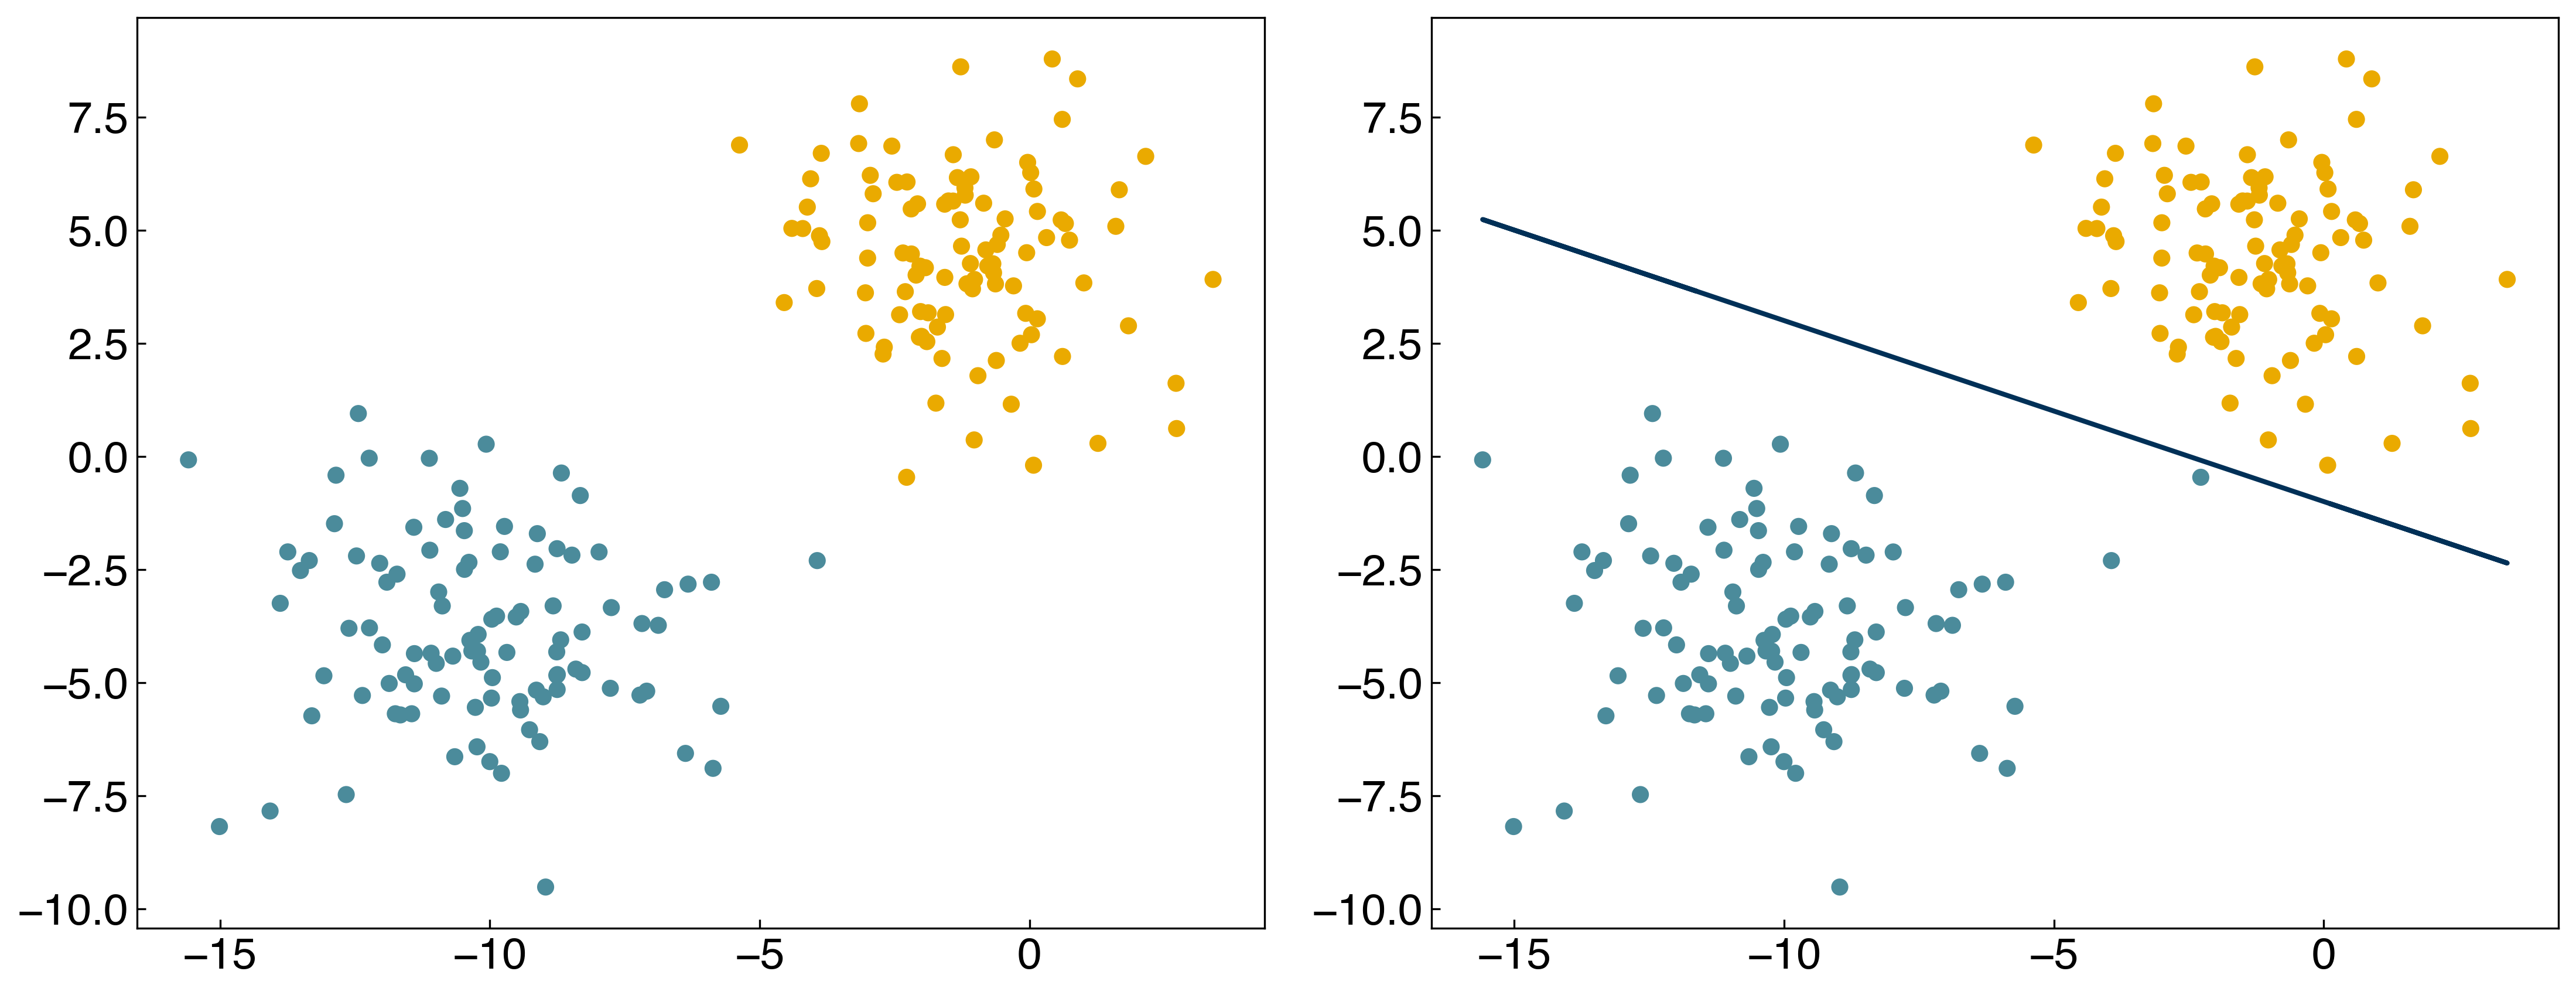

In [17]:
from scipy.optimize import minimize

result = minimize(n_wrong, w)

w_count = result.x
print(n_wrong(w_count))

prediction = linear_classifier(X, w_count)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[(y + 3) // 2])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w_count[1] / w_count[2]
b = -w_count[0] / w_count[2]
axes[1].plot(X[:, 0], m*X[:, 0] + b, ls = '-')
result;

The problem is that the "sign" function is not differentiable! This makes it a bad loss function. In general, we expect that minimizing the loss functions should also minimize the number of incorrect points, but this isn't always the case.

### Discussion: What are some differences between these two loss functions?

> The max cost function tells how far the input is from the discrimination line, while the counting loss function only tells the number of misclassification.